# Imports

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cvxopt import matrix, solvers
from functools import partial
from numba import njit
import itertools
import time

# Usefull function

## Loading data

In [14]:
def train_set(X_path,Y_path, seq = ['A', 'C', 'G', 'T']): 
    #x_train data
    x = pd.read_csv(X_path)
    x = x['seq'].str.split('',expand = True)
    x = x.drop(columns =0)
    x = x.drop(columns = 102)
    x = x.values
    lst = []
    for item in seq: 
        lst.append(np.where(x == item,1,0))
    x_train = np.stack(lst,axis =2)

    #y_train 
    y = pd.read_csv(Y_path)
    y_train = y['Bound'].values

    return x_train, y_train

In [15]:
def test_set(test_path, seq = ['A', 'C', 'G', 'T']): 
    #x_test data
    x = pd.read_csv(test_path)
    x = x['seq'].str.split('',expand = True)
    x = x.drop(columns =0)
    x = x.drop(columns = 102)
    x = x.values
    lst = []
    for item in seq: 
        lst.append(np.where(x == item,1,0))
    x_test = np.stack(lst,axis =2)
    
    return x_test

## Evaluation and Model description

In [57]:
def cross_validation(model, X, y, nfold = 5):
    # data fold up setting
    indices = np.arange(y.shape[0])
    np.random.shuffle(indices)
    partition = np.split(indices,nfold)

    lst_score = []
    for i in range(nfold): 

        #training phase
        train_idx = partition.copy()
        train_idx.pop(i)
        train_idx = np.array(train_idx).flatten()
        model.fit(X[train_idx], y[train_idx])

        #scoring
        score, predictions = model.score(X[partition[i]], y[partition[i]])
        lst_score.append(score)

        print(f"Fold: {i+1}/{nfold} -- Score: {round(score, 3)}, Positive rate : {y[partition[i]].sum()/len(y[partition[i]])}")#, Prediction : {predictions}")

    print(f"Validation done -- Mean Score {round(np.mean(lst_score), 3)}, Std : {round(np.std(lst_score), 3)}")
    return lst_score

In [17]:
def ParameterGrid(dct): 
    """
    Args: 
    dct : dictionnary, must be {'kernel' : fct , 'kernel_params': dictionnary , 'model_params' : dictionnary}

    Return:
    """
    import itertools
    from functools import partial
    f_dcts = dct['model_params']
    # kernels 
    k_keys, k_values = zip(*dct['kernel_params'].items())
    k_params_dcts = [dict(zip(k_keys, v)) for v in itertools.product(*k_values)]
    f_dcts['kernel'] = [partial(dct['kernel'],**k_dct) for k_dct in k_params_dcts]
    # final grid
    keys, values = zip(*f_dcts.items())
    f_dcts = [dict(zip(keys, v)) for v in itertools.product(*values)]
    return f_dcts

In [18]:
def GridSearchCV(model,param_dct,X,y,nfold =5): 
    """
    Args: 
    model : class 
    param_dct : parameter_gri
    nfold : int 
    Return: 
    log_dct : return 
    best_model
    best_model_params
    """
    from copy import deepcopy
    param_dcts = ParameterGrid(param_dct)
    best_score =0
    best_model_params = None
    best_model = None
    log = {}
    n = 0
    for dct in param_dcts: 
        tmodel = model(**dct)
        score_lst = cross_validation(tmodel,X,y,nfold)
        mean_score = np.mean(score_lst)

        log[f'setting_{n}'] = {
            'params' : dct,
            'scores' : score_lst,
            'mean_score' : mean_score
        }

        if mean_score > best_score: 
            best_score = mean_score.copy()
            best_model_params = deepcopy(dct)
            best_model = deepcopy(tmodel)
        
        n+=1

        print(f'Ireration: {n}/{len(param_dcts)} -- Mean_Score: {mean_score}')
    
    print('GirdSearch Done.')

    return log, best_model, best_model_params

# Model 

## Model Functions

In [19]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

## Kernel

### Gaussian kernel

In [20]:
def gaussian_kernel(X, Y, sigma = 1, typ = 'matrix'):
    """
    Args: 
    X: np.array, shape (batch_X, ...)
    Y: np.array, shape (batch_Y , ...)
    sigma : std
    
    Return: np.array, Kernel, shape(batch_X, batch_Y)
    """ 
    diff = X[:, None] - Y[None]
    if typ == 'matrix':
        diff = (diff**2).sum(axis = (2, 3))
    else:
        diff = (diff**2).sum(axis = 2)
    return np.exp(-diff/(2*sigma**2))

### Linear kernel

In [21]:
def linear_kernel(X, Y):
    """
    Args: 
    X: np.array, shape (batch_X, ...)
    Y: np.array, shape (batch_Y , ...)
    
    Return: np.array, Kernel, shape(batch_X, batch_Y)
    """ 
    X_flat = X.reshape((X.shape[0], -1))
    Y_flat = Y.reshape((Y.shape[0], -1))
    return X_flat@Y_flat.T

### Mismatch kernel

In [22]:
@njit
def similarity(lst, X, Y, length, mismatch, λ, norm = True):
    l = X.shape[0]
    k = X.shape[1]
    n = Y.shape[0]
    z = lst.shape[0]
    simx = np.zeros((l, z))
    simy = np.zeros((n, z))

    # Compute representation of X and Y
    for j in range(z):
        sample = lst[j]                                    
        for m in range(k - length + 1):
            for h in range(l):
                sample2 = X[h, m:(m+length)]
                mis = (np.abs(sample - sample2)).sum()/2
                if mis <= mismatch:
                    simx[h, j] += λ**mis

            for h in range(n):
                sample2 = Y[h, m:(m+length)]
                mis = (np.abs(sample - sample2)).sum()/2
                if mis <= mismatch:
                    simy[h, j] += λ**mis

    if norm:
        normx = np.sqrt((simx**2).sum(axis = 1)).reshape(-1, 1)
        normy = np.sqrt((simy**2).sum(axis = 1)).reshape(-1, 1)
        K = simx@simy.T/(normx@normy.T)
    else:
        K = simx@simy.T      
    
    return K

def mismatch_kernel(X, Y, length = 6, mismatch = 1, λ = 1, norm = True):
    """
    Args: 
    X: np.array, shape (batch_X, 101, 4)
    Y: np.array, shape (batch_Y , 101, 4)
    
    Return: np.array, Kernel, shape(batch_X, batch_Y)
    """ 
    lst = np.array(list(itertools.product(np.eye(X.shape[2]), repeat = length)))
    K = similarity(lst, X, Y, length, mismatch, λ, norm)
            
    return K

Sanity check with an already implemented mismatch kernel. If you want to run this cell you need to install the library ```strkernel```. Moreover, if you want to have the real computation time of our kernel you need to run it twice because the first time numba will "translate" the code and it takes some time.

In [23]:
from strkernel.mismatch_kernel import MismatchKernel, preprocess
x = pd.read_csv('Training/Xtr0.csv')
x = np.array(x['seq'])[:20]
x = preprocess(x)
start = time.time()
MisKern = MismatchKernel(l = 4, k = 4, m = 1)
kern = MisKern.get_kernel(x, normalize = True).kernel
print('Time elapsed for the kernel from the library:', time.time() - start)

X_path = 'Training/Xtr0.csv'
Y_path = 'Training/Ytr0.csv'
trainset, label = train_set(X_path,Y_path, seq = ['A', 'C', 'G', 'T'])
label = label.astype('float')
trainset = trainset[:20]

start = time.time()
kernel = partial(mismatch_kernel, length = 4, mismatch = 1, norm = True)
kern2 = kernel(trainset, trainset)
print('Time elapsed for our kernel:', time.time() - start)

assert np.allclose(kern, kern2)

Time elapsed for the kernel from the library: 0.18743491172790527
Time elapsed for our kernel: 1.2494463920593262


### Sum of kernels

In [40]:
def SumKernels(X, Y, kernels):
    n, l = X.shape[0], Y.shape[0]
    K = np.zeros((n, l))
    for kernel in kernels:
        K += kernel(X, Y)
    
    return K/len(kernels)

## Model 

In [24]:
class ClassificationBaseModel: 

    def __init__(self,kernel): 
        """
        Args: 
        - Kernel: python callable fct

        Notes: 
        BaseModel is based on representer theorem. Function fit has to compute the kernel_params array and set is_fitted to True once it is done.
        """
        self.kernel = kernel
        self.is_fitted = False
        self.kernel_params = None
        self.dataset = None
        self.label = None


    def fit(self,X,y): 
        self.dataset = X
        if np.unique(y).sum() == 1:
            self.label = 2*y - 1
        else:
            self.label = y
            
    def predict(self, X): 
        if self.is_fitted: 
            predictions = np.sum(self.comparison_matrix(X, self.dataset)@np.diag(self.kernel_params), axis=1)
            return (np.sign(predictions) + 1)/2
        else: 
            print('Model not fitted')
            
    def score(self, X, y): 
        n_samples = y.shape[0]
        predictions = self.predict(X)
        score = 1 - np.sum(np.abs(predictions-y))/n_samples
        return score, predictions
    
    def comparison_matrix(self,X,Y):
        """
        Args: 
        X,Y,: np.array, first dim number of samples

        Return 
        compmatrix : np.array, comparison matrix, shape : (X.shape[0], Y.shape[0])
        """
        return self.kernel(X, Y)
    
    def gram_matrix(self,X): 
        return self.kernel(X, X)

In [25]:
class KLR(ClassificationBaseModel): 
    def __init__(self,kernel,reg,tol=1e-9):
        super().__init__(kernel)
        self.reg = reg
        self.tol = tol
    
    def fit(self,X,y): 
        super().fit(X,y)
        gram = self.gram_matrix(X)
        self.kernel_params = self.KLR(gram = gram,label = self.label,reg =self.reg,tol = self.tol)
        self.is_fitted = True
        print('Model Fitted')
    
    def predict(self, X): 
        return super().predict(X)
    
    def KLR(self,gram, label, reg, tol):
        n = gram.shape[0]
        assert np.allclose(n, len(label)), 'labels must have the same length as the dimension of the gramian matrix'
        α = np.zeros(n)
        cond = True
        k = 0
        while cond:
            k += 1
            old_α = α.copy()
            m = gram@α
            W = np.diag(np.sqrt(sigmoid(m)*sigmoid(-m)))
            z = m + label/sigmoid(label*m)
            α = W@np.linalg.solve(W@gram@W + n*reg*np.eye(n), W@z)
            cond = (np.linalg.norm(old_α - α) > tol)
        print(k)
        return α

In [26]:
class KSVM(ClassificationBaseModel): 
    def __init__(self,kernel,reg, threshold = None):
        super().__init__(kernel)
        self.reg = reg
        self.threshold = threshold
    
    def fit(self, X, y): 
        super().fit(X,y)
        gram = self.gram_matrix(X)
        self.kernel_params = self.KSVM(gram = gram,label = self.label,reg =self.reg, threshold = self.threshold)
        self.is_fitted = True
        print('Model Fitted')

    def predict(self, X):
        '''
        Arg: 
        X: np.array, first dim number of samples 
        '''
        if self.is_fitted:
            predictions = ((self.label*self.kernel_params[0])@self.comparison_matrix(self.dataset, X) + self.kernel_params[1]).squeeze()
            return (np.sign(predictions) + 1)/2
        else: 
            print('Model not fitted')

    def KSVM(self,gram, label, reg, threshold):
        label = label.squeeze()
        if np.unique(label).sum() == 1:
            label = 2*label - 1
        n = gram.shape[0]
        C = 1/(2*n*reg)
        assert np.allclose(n, len(label)), 'labels must have the same length as the dimension of the gramian matrix'
        labelm = np.diag(label)
        K = matrix(labelm@gram@labelm)
        G = matrix(np.vstack([np.eye(n), -np.eye(n)]))
        A = matrix(label.reshape(1, n))    
        h = matrix(np.vstack([C*np.ones((n, 1)), np.zeros((n, 1))]))
        y = matrix(-np.ones((n, 1)))
        d = matrix(np.zeros(1))
        solvers.options['show_progress'] = False
        α = np.array(solvers.qp(K, y, G, h, A, d)['x']).squeeze()
#         α[α < threshold] = 0.
        α[α > C*0.99] = C
        if ((α > C*0.1)*(α < C)).sum() > 0 :
            idx = np.min(np.where(((α > C*0.1)*(α < C)).astype('bool')))
            b = label[idx] - (α*label)@gram[:, idx]
        else:
            b = 0
        return α, b, C

# Test

In [18]:
from sklearn.datasets import make_moons

sns.set()
X,Y = make_moons(1000,random_state =1, noise = 0)
X_train = X[:900]
Y_train = Y[:900].astype('float')
X_test = X[:100]
Y_test = Y[:100].astype('float')

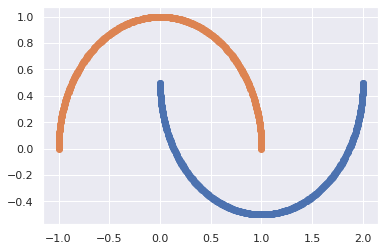

In [19]:
plt.scatter(X_train[np.where(Y_train==1),0],X_train[np.where(Y_train==1),1])
plt.scatter(X_train[np.where(Y_train==0),0],X_train[np.where(Y_train==0),1]);

In [22]:
kernel = partial(gaussian_kernel, sigma = .1, typ = 'vector')
model = KSVM(kernel, reg=1e-3, threshold = 1e-4)
cross_validation(model, X_train, Y_train, nfold = 3)

Model Fitted
Fold: 1/3 -- Score: 1.0, Positive rate : 0.49666666666666665
Model Fitted
Fold: 2/3 -- Score: 1.0, Positive rate : 0.5266666666666666
Model Fitted
Fold: 3/3 -- Score: 1.0, Positive rate : 0.4866666666666667
Validation done -- Mean Score 1.0


[1.0, 1.0, 1.0]

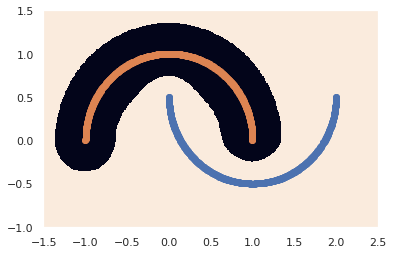

In [23]:
x = np.linspace(-1.5, 2.5, 400)
y = np.linspace(-1., 1.5, 250)
X, Y = np.meshgrid(x, y)
Z = np.stack([X, Y]).T.reshape(-1, 2)
f = model.predict(Z).reshape(400, 250).T

plt.pcolor(X, Y, f, shading = 'auto')
plt.scatter(X_train[Y_train==1,0],X_train[Y_train==1,1])
plt.scatter(X_train[Y_train==0,0],X_train[Y_train==0,1])
plt.show()

In [24]:
model = KLR(partial(gaussian_kernel, sigma = 0.1, typ = 'vector'),reg=1e-2)
cross_validation(model, X_train, Y_train, nfold = 3)

5
Model Fitted
Fold: 1/3 -- Score: 1.0, Positive rate : 0.5633333333333334
5
Model Fitted
Fold: 2/3 -- Score: 1.0, Positive rate : 0.4866666666666667
5
Model Fitted
Fold: 3/3 -- Score: 1.0, Positive rate : 0.46
Validation done -- Mean Score 1.0


[1.0, 1.0, 1.0]

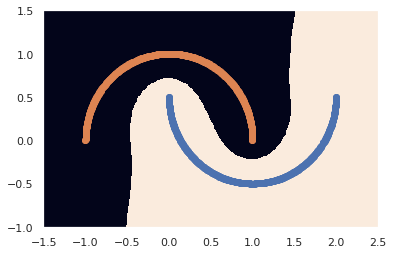

In [25]:
x = np.linspace(-1.5, 2.5, 400)
y = np.linspace(-1., 1.5, 250)
X, Y = np.meshgrid(x, y)
Z = np.stack([X, Y]).T.reshape(-1, 2)
f = model.predict(Z).reshape(400, 250).T

plt.pcolor(X, Y, f, shading = 'auto')
plt.scatter(X_train[Y_train==1,0],X_train[Y_train==1,1])
plt.scatter(X_train[Y_train==0,0],X_train[Y_train==0,1])
plt.show()

In [35]:
X_path = 'Training/Xtr0.csv'
Y_path = 'Training/Ytr0.csv'
trainset, label = train_set(X_path,Y_path, seq = ['A', 'C', 'G', 'T'])
label = label.astype('float')
# trainset, label = trainset[:600], label[:600]

In [17]:
start = time.time()
trainset, label = trainset[:200], label[:200]
kernel = partial(mismatch_kernel, length = 4, mismatch = 1, λ = .9, norm = True)
model = KSVM(kernel, reg = 1e-6)
model.fit(trainset, label)
print(time.time() - start)

Model Fitted
0.9942288398742676


In [47]:
kernel1 = partial(mismatch_kernel, length = 3, mismatch = 0, λ = 1, norm = True)
kernel2 = partial(mismatch_kernel, length = 4, mismatch = 0, λ = 1, norm = True)
kernel3 = partial(mismatch_kernel, length = 5, mismatch = 0, λ = 1, norm = True)
kernel4 = partial(mismatch_kernel, length = 4, mismatch = 1, λ = 1, norm = True)
kernel5 = partial(mismatch_kernel, length = 5, mismatch = 1, λ = 1, norm = True)
kernel6 = partial(mismatch_kernel, length = 4, mismatch = 1, λ = .5, norm = True)
kernel7 = partial(mismatch_kernel, length = 5, mismatch = 1, λ = .5, norm = True)
kernel8 = partial(gaussian_kernel, sigma = 1)
kernel9 = partial(gaussian_kernel, sigma = 3)
kernel10 = partial(gaussian_kernel, sigma = 10)
kernels = [kernel1, kernel2, kernel3, kernel4, kernel5, kernel6, kernel7, kernel8, kernel9, kernel10]

In [48]:
dct = {
    'kernel' : SumKernels,
    'kernel_params' : {
        'kernels' : [kernels],
    },
    'model_params' : {
        'reg' : [1e-3, 1e-4, 1e-5],
        'threshold' : [None] 
    }
}

X_path = 'Training/Xtr0.csv'
Y_path = 'Training/Ytr0.csv'
trainset, label = train_set(X_path,Y_path, seq = ['A', 'C', 'G', 'T'])
label = label.astype('float')
# trainset, label = trainset[:600], label[:600]

log0, best_model, params0 = GridSearchCV(KSVM, dct, trainset, label, 5)

X_path = 'Training/Xtr1.csv'
Y_path = 'Training/Ytr1.csv'
trainset, label = train_set(X_path,Y_path, seq = ['A', 'C', 'G', 'T'])
label = label.astype('float')
# trainset, label = trainset[:600], label[:600]

log1, best_model, params1 = GridSearchCV(KSVM, dct, trainset, label, 5)

X_path = 'Training/Xtr2.csv'
Y_path = 'Training/Ytr2.csv'
trainset, label = train_set(X_path,Y_path, seq = ['A', 'C', 'G', 'T'])
label = label.astype('float')
# trainset, label = trainset[:600], label[:600]

log2, best_model, params2 = GridSearchCV(KSVM, dct, trainset, label, 5)

Model Fitted
Fold: 1/5 -- Score: 0.633, Positive rate : 0.4875
Model Fitted
Fold: 2/5 -- Score: 0.63, Positive rate : 0.4675
Model Fitted
Fold: 3/5 -- Score: 0.645, Positive rate : 0.495
Model Fitted
Fold: 4/5 -- Score: 0.6, Positive rate : 0.465
Model Fitted
Fold: 5/5 -- Score: 0.612, Positive rate : 0.49
Validation done -- Mean Score 0.624
Ireration: 1/3 -- Mean_Score: 0.624
Model Fitted
Fold: 1/5 -- Score: 0.635, Positive rate : 0.515
Model Fitted
Fold: 2/5 -- Score: 0.61, Positive rate : 0.4875
Model Fitted
Fold: 3/5 -- Score: 0.662, Positive rate : 0.4425
Model Fitted
Fold: 4/5 -- Score: 0.675, Positive rate : 0.49
Model Fitted
Fold: 5/5 -- Score: 0.595, Positive rate : 0.47
Validation done -- Mean Score 0.636
Ireration: 2/3 -- Mean_Score: 0.6355000000000001
Model Fitted
Fold: 1/5 -- Score: 0.635, Positive rate : 0.47
Model Fitted
Fold: 2/5 -- Score: 0.61, Positive rate : 0.505
Model Fitted
Fold: 3/5 -- Score: 0.633, Positive rate : 0.4725
Model Fitted
Fold: 4/5 -- Score: 0.685, P

In [55]:
X_path = 'Training/Xtr0.csv'
Y_path = 'Training/Ytr0.csv'
trainset, label = train_set(X_path,Y_path, seq = ['A', 'C', 'G', 'T'])
label = label.astype('float')

kernel = partial(SumKernels, kernels = kernels)
model = KSVM(kernel, reg = 1e-4)
model.fit(trainset, label)
test_path = 'Test/Xte0.csv'
testset = test_set(test_path, seq = ['A', 'C', 'G', 'T'])
test_label0 = model.predict(testset)

X_path = 'Training/Xtr1.csv'
Y_path = 'Training/Ytr1.csv'
trainset, label = train_set(X_path,Y_path, seq = ['A', 'C', 'G', 'T'])
label = label.astype('float')

kernel = partial(SumKernels, kernels = kernels)
model = KSVM(kernel, reg = 1e-4)
model.fit(trainset, label)
test_path = 'Test/Xte1.csv'
testset = test_set(test_path, seq = ['A', 'C', 'G', 'T'])
test_label1 = model.predict(testset)

X_path = 'Training/Xtr2.csv'
Y_path = 'Training/Ytr2.csv'
trainset, label = train_set(X_path,Y_path, seq = ['A', 'C', 'G', 'T'])
label = label.astype('float')

kernel = partial(SumKernels, kernels = kernels)
model = KSVM(kernel, reg = 1e-4)
model.fit(trainset, label)
test_path = 'Test/Xte2.csv'
testset = test_set(test_path, seq = ['A', 'C', 'G', 'T'])
test_label2 = model.predict(testset)

test_label = np.vstack([np.array([i for i in range(3000)]), np.hstack([test_label0, test_label1, test_label2])]).T.astype('int')
test_label = pd.DataFrame(test_label, columns = ['Id', 'Bound'])
test_label.to_csv('test_label_sum.csv', index = False)

Model Fitted
Model Fitted
Model Fitted


In [56]:
X_path = 'Training/Xtr0.csv'
Y_path = 'Training/Ytr0.csv'
trainset, label = train_set(X_path,Y_path, seq = ['A', 'C', 'G', 'T'])
label = label.astype('float')

kernel = partial(mismatch_kernel, length = 5, mismatch = 1, λ = .5, norm = True)
model = KSVM(kernel, reg = 1e-4)
model.fit(trainset, label)
test_path = 'Test/Xte0.csv'
testset = test_set(test_path, seq = ['A', 'C', 'G', 'T'])
test_label0 = model.predict(testset)

X_path = 'Training/Xtr1.csv'
Y_path = 'Training/Ytr1.csv'
trainset, label = train_set(X_path,Y_path, seq = ['A', 'C', 'G', 'T'])
label = label.astype('float')

kernel = partial(mismatch_kernel, length = 5, mismatch = 1, λ = .5, norm = True)
model = KSVM(kernel, reg = 1e-3)
model.fit(trainset, label)
test_path = 'Test/Xte1.csv'
testset = test_set(test_path, seq = ['A', 'C', 'G', 'T'])
test_label1 = model.predict(testset)

X_path = 'Training/Xtr2.csv'
Y_path = 'Training/Ytr2.csv'
trainset, label = train_set(X_path,Y_path, seq = ['A', 'C', 'G', 'T'])
label = label.astype('float')

kernel = partial(mismatch_kernel, length = 5, mismatch = 1, λ = .5, norm = True)
model = KSVM(kernel, reg = 5e-4)
model.fit(trainset, label)
test_path = 'Test/Xte2.csv'
testset = test_set(test_path, seq = ['A', 'C', 'G', 'T'])
test_label2 = model.predict(testset)

test_label = np.vstack([np.array([i for i in range(3000)]), np.hstack([test_label0, test_label1, test_label2])]).T.astype('int')
test_label = pd.DataFrame(test_label, columns = ['Id', 'Bound'])
test_label.to_csv('test_label_mismatch.csv', index = False)

Model Fitted
Model Fitted
Model Fitted


In [58]:
X_path = 'Training/Xtr0.csv'
Y_path = 'Training/Ytr0.csv'
trainset, label = train_set(X_path,Y_path, seq = ['A', 'C', 'G', 'T'])
label = label.astype('float')

kernel = partial(mismatch_kernel, length = 5, mismatch = 1, λ = .5, norm = True)
model = KSVM(kernel, reg = 1e-4)
cross_validation(model, trainset, label, nfold = 5)

X_path = 'Training/Xtr1.csv'
Y_path = 'Training/Ytr1.csv'
trainset, label = train_set(X_path,Y_path, seq = ['A', 'C', 'G', 'T'])
label = label.astype('float')

kernel = partial(mismatch_kernel, length = 5, mismatch = 1, λ = .5, norm = True)
model = KSVM(kernel, reg = 1e-3)
cross_validation(model, trainset, label, nfold = 5)

X_path = 'Training/Xtr2.csv'
Y_path = 'Training/Ytr2.csv'
trainset, label = train_set(X_path,Y_path, seq = ['A', 'C', 'G', 'T'])
label = label.astype('float')

kernel = partial(mismatch_kernel, length = 5, mismatch = 1, λ = .5, norm = True)
model = KSVM(kernel, reg = 5e-4)
cross_validation(model, trainset, label, nfold = 5)

Model Fitted
Fold: 1/5 -- Score: 0.612, Positive rate : 0.485
Model Fitted
Fold: 2/5 -- Score: 0.61, Positive rate : 0.49
Model Fitted
Fold: 3/5 -- Score: 0.648, Positive rate : 0.51
Model Fitted
Fold: 4/5 -- Score: 0.607, Positive rate : 0.4425
Model Fitted
Fold: 5/5 -- Score: 0.6, Positive rate : 0.4775
Validation done -- Mean Score 0.616, Std : 0.017
Model Fitted
Fold: 1/5 -- Score: 0.525, Positive rate : 0.4875
Model Fitted
Fold: 2/5 -- Score: 0.61, Positive rate : 0.515
Model Fitted
Fold: 3/5 -- Score: 0.64, Positive rate : 0.5
Model Fitted
Fold: 4/5 -- Score: 0.628, Positive rate : 0.5025
Model Fitted
Fold: 5/5 -- Score: 0.643, Positive rate : 0.4975
Validation done -- Mean Score 0.609, Std : 0.044
Model Fitted
Fold: 1/5 -- Score: 0.685, Positive rate : 0.525
Model Fitted
Fold: 2/5 -- Score: 0.748, Positive rate : 0.47
Model Fitted
Fold: 3/5 -- Score: 0.738, Positive rate : 0.485
Model Fitted
Fold: 4/5 -- Score: 0.71, Positive rate : 0.5
Model Fitted
Fold: 5/5 -- Score: 0.715, Po

[0.685, 0.7475, 0.7375, 0.71, 0.7150000000000001]